## Pretrained GAN

In [1]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.vision.gan import *

Untar the data at `URLs.PETS` and save the path to `path`.

In [4]:
path = untar_data(URLs.PETS)
path_hr = path/'images'
path_lr = path/'crappy'

## Crappified data

In [5]:
from crappify import *

Set `il` to an `ImageList` from the folder `path_hr`. In parallel call `crappifier` with `path_lr` aand `path_hr` as arguments over `il.items`.

In [7]:
il = ImageList.from_folder(path_hr)
parallel(partial(crappifier, path_lr, path_hr), il.items)

Set `bs,size` to `32, 128`. Set `arch` to a resnet34.

In [8]:
bs, size = 32, 128
arch = models.resnet34

## Pre-train generator

Now let's pretrain the generator.

Set arch to a resnet34. Create an `ImageItemList` from the folder `path_lr`, split it by a random (10) percent with a random seed of 42. Assign it to `src`.

In [10]:
arch = models.resnet34
src = ImageImageList.from_folder(path_lr).split_by_rand_pct(0.1, seed=42)

Create a function `get_data` that takes `src`, labels from a one-arg function that connects `path_hr` and `arg.name`, transform it with `get_transforms(max_zoom=2.)`, size is what you set above, and `tfm_y` should be `True` (Why is the last part important?); we should then call `databunch` using our `bs` from eaarlier, normalize with `imagenet_stats` and normalize the `y` values as well. Set `data.c` to 3 (can you explain why?) and return `data`.

In [19]:
def get_data(bs, size):
    data = (src.label_from_func(lambda x: path_hr/x.name)
            # we need to transform the y's because the x image and the y image
            # should be the same except for crappification
            .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
            .databunch(bs=bs)
            .normalize(imagenet_stats, do_y=True))
    # I think this sets the number of categories to 3, but I'm not sure
    # why that's important in a GAN given that it's not actually a classifier.
    data.c = 3
    return data

Set `data_gen` to `get_data(bs, size)`.

In [20]:
data_gen = get_data(bs, size)

Show 4 examples from the next batch.

In [21]:
%matplotlib inline

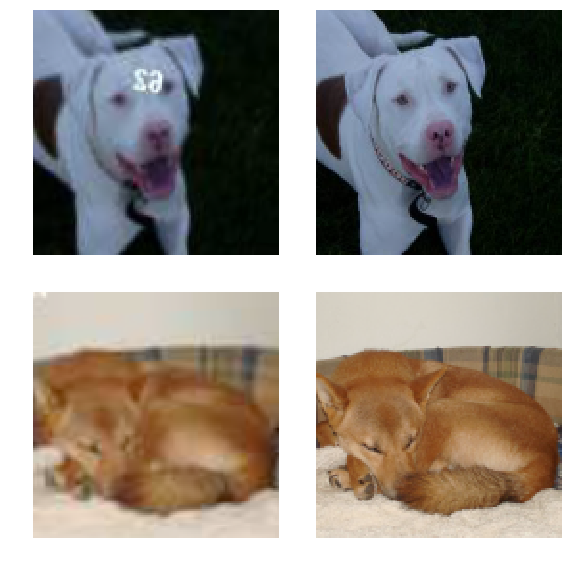

In [22]:
data_gen.show_batch(rows=2)

In [23]:
%matplotlib inline

Set `wd` to `1e-3`.

In [24]:
wd = 1e-3

Set the `y_range` to `(-3., 3.)`.

In [25]:
y_range = (-3., 3.)

Set `loss_gen` to `MSELossFlat`.

In [34]:
loss_gen = MSELossFlat()

Create a function `create_gen_learner` that creates a `unet_learner` that uses `data_gen`, `arch`, `wd`, sets `blur` to True (what does this do?), `norm_type=NormType.Weight` (what does this do?), `self_attention=True` (what does this do?), `y_range` and `loss_func=loss_gen`.

In [38]:
def create_gen_learner():
    # blur determins whether the image gets blurred during upsampling (I think? or maybe downsampling)
    # norm_type determines the type of normalization to be performed, one being weight normalization
    # self_attention is a technique that allows you to generate detail dependencies that span large distances across 
    # the image. there's a paper on it.
    return unet_learner(
        data_gen, arch, wd=wd, blur=True, norm_type=NormType.Weight, self_attention=True, 
        y_range=y_range, loss_func=loss_gen)

create_gen_learner and assign it to `learn_gen`.

In [39]:
learn_gen = create_gen_learner()

Fit a cycle with 2 epochs and `pct_start=0.8`. What does `pct_start` do?

In [40]:
# pct_start specifies the percentage of processed batches that are a part of the first learning phase
learn_gen.fit_one_cycle(2, pct_start=0.8)

epoch,train_loss,valid_loss,time
0,0.066439,0.054267,02:47
1,0.052758,0.048608,02:36


Unfreeze the model.

In [41]:
learn_gen.unfreeze()

Train it again for another 3-epoch cycle with an lr slice from 1e-6 to 1e-3.

In [42]:
learn_gen.fit_one_cycle(3, slice(1e-6, 1e-3))

epoch,train_loss,valid_loss,time
0,0.051009,0.048178,02:46
1,0.048580,0.045305,02:46
2,0.046939,0.044146,02:46


Show the results with 4 rows.

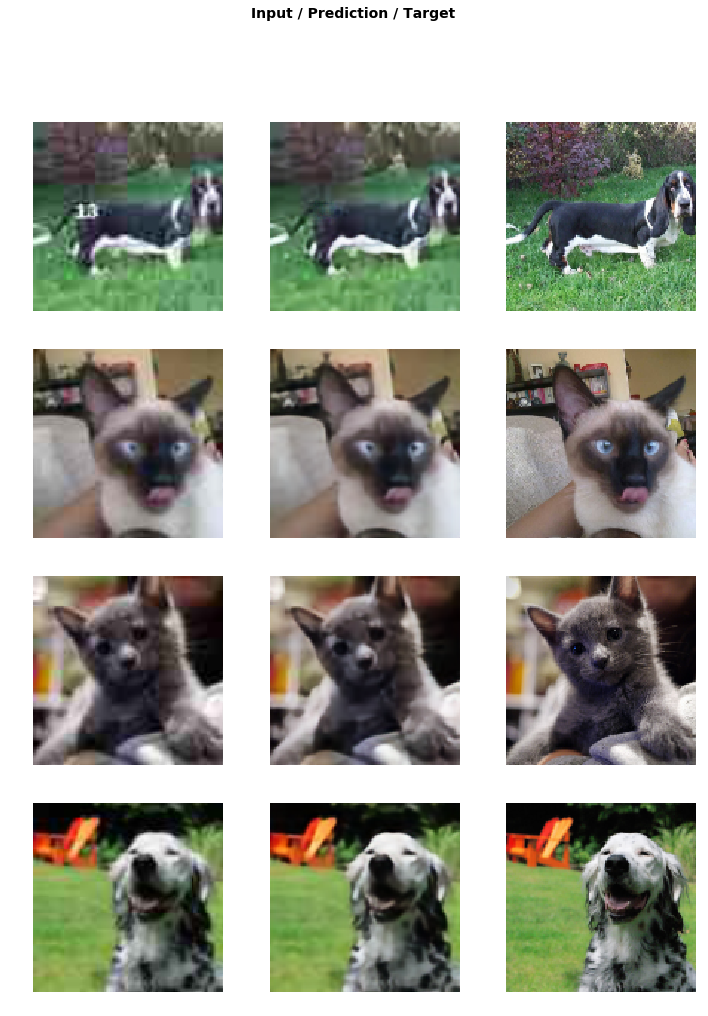

In [43]:
learn_gen.show_results(rows=4)

Save the learner to gen-pre2.

In [46]:
learn_gen.save("gen-pre2")

## Save generated images

Load the learner `gen-pre2`.

In [47]:
learn_gen.load("gen-pre2")

Learner(data=ImageDataBunch;

Train: LabelList (6651 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /home/paperspace/.fastai/data/oxford-iiit-pet/crappy;

Valid: LabelList (739 items)
x: ImageImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
Path: /home/paperspace/.fastai/data/oxford-iiit-pet/crappy;

Test: None, model=DynamicUnet(
  (layers): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, p

Set `name_gen` to `image_gen`, and set `path_gen` to `path/name_gen`.

In [48]:
name_gen = "image_gen"
path_gen = path/name_gen

Create `path_gen` (Hint: check out the `mkdir` method of a path object). What does `exist_ok` do?

In [51]:
# exist_ok prevents an error in the case where the directory already exists
os.makedirs(path_gen, exist_ok=True)

Write a function `save_preds` that takes in a data loader `dl`, iterates over the batches in that data loader, predicts images over each batch, and saves each image to `path_gen` with the same name as it had in the original dataset. Take advantage of `dl.dataset.items` to get the list of names from the data loader. Hint: you'll have to do a bit of looping here.

In [56]:
def save_preds(dl: DataLoader):
    i = 0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds: 
            o.save(path_gen/names[i].name)
            i += 1

Call `save_preds` on `data_gen.fix_dl`. What does `fix_dl` do?

In [57]:
save_preds(data_gen.fix_dl)

In [58]:
# fix_dl is like train_dl but without transforms or shuffling

Use `PIL` to open the first image in `path_gen`.

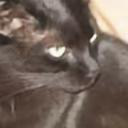

In [59]:
PIL.Image.open(path_gen.ls()[0])

## Train critic

Set `learn_gen` to `None`. Call `gc.collect`.

In [61]:
learn_gen = None; gc.collect()

0

Create a function `get_crit_data` that takes as arguments `classes`, `bs`, `size`. It will:
- Take an ImageList and split away a random 10% for validation with a random seed of 42
- Transform with the default transforms except `max_zoom=2.`, size=size
- turn it into a databunch with batch size bs anr normalize with imagenet stats
- set the number of categories to 3

In [75]:
def get_crit_data(classes, bs, size):
    il = ImageList.from_folder(path, include=classes).split_by_rand_pct(0.1, seed=42)
    data = (il
    .label_from_folder(classes=classes)
    .transform(get_transforms(max_zoom=2.), size=size)
    .databunch(bs=bs)
    .normalize(imagenet_stats))
    data.c = 3
    return data 

set `data_crit` to the result of `get_crit_data` with arguments `[name_gen, 'images']`, `bs=bs`, `size=size`.  

In [76]:
data_crit = get_crit_data([name_gen, "images"], bs=bs, size=size)

/home/paperspace/anaconda3/lib/python3.6/site-packages/fastai/data_block.py:525: UserWarning: You are labelling your items with CategoryList.
Your train set contained the following unknown labels, the corresponding items have been discarded.
oxford-iiit-pet
  if getattr(ds, 'warn', False): warn(ds.warn)


Show a batch over 3 rows with ds type `Train` and imgsize=3.

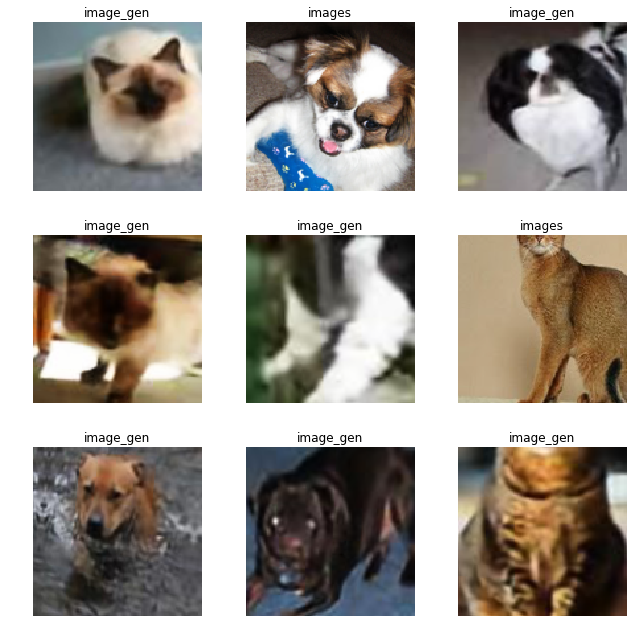

In [77]:
data_crit.show_batch(rows=3, imgsize=3)

Set `loss_critic` to `AdaptiveLoss` with argument `nn.BCEWithLogitsLoss()`. What is this doing?

In [79]:
# BCEWithLogitsLoss is a sigmoid layer and a binary cross entropy rolled into one
loss_critic = AdaptiveLoss(nn.BCEWithLogitsLoss())

Create a function `create_critic_learner` that takes arguments `data`, `metrics`. It should return a `Learner` object with arguments `data`, `gan_critic()`, `metrics=metrics`, `loss_function=loss_critic`, `wd=wd`. Can you explain what each of these is doing?

In [83]:
def create_critic_learner(data, metrics):
    return Learner(data, gan_critic(), metrics=metrics, loss_func=loss_critic, wd=wd)

Use `create_critic_learner` to create a learner `learn_critic`.

In [84]:
learn_critic = create_critic_learner(data_crit, accuracy_thresh_expand)

Fit a 6-epoch cycle with a max lr of 1e-3.

In [ ]:
learn_critic.fit_one_cycle(6, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy_thresh_expand,time
0,0.677145,0.665937,0.554273,06:36
1,0.380471,0.448345,0.801510,06:29
2,0.182773,0.099099,0.968091,06:28
3,0.116007,0.128242,0.946980,06:28
4,0.070561,0.116675,0.956097,06:28
5,0.044621,0.064025,0.976809,06:28


Save the model as `critic-pre2`.

In [88]:
learn_critic.save("critic-pre2")

In [89]:
learn_critic.load("critic-pre2")

Learner(data=ImageDataBunch;

Train: LabelList (12637 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
images,images,images,images,images
Path: /home/paperspace/.fastai/data/oxford-iiit-pet;

Valid: LabelList (1404 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
image_gen,image_gen,image_gen,images,image_gen
Path: /home/paperspace/.fastai/data/oxford-iiit-pet;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace)
  )
  (1): Dropout2d(p=0.075)
  (2): SequentialEx(
    (layers): ModuleList(
      (0): Sequential(
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.2, inplace)
      )
      (1): Sequential(
        (0): Conv2d(128, 

## GAN

Set `learn_crit` and `learn_gen` to `None`, and do another round of GPU garbage collection.

In [60]:
learn_crit = None
learn_gen = None
gc.collect()

4100

Load the crit data from dirs `['crappy', 'images']`, `bs=bs`, `size=size`.

Recreate the critic learner from the dad you just loaded with no metrics, and load `critic-pre2`.

Create a gen learner and load `gen-pre2`.

Create a `GANLearner`. There are a few pieces here:
- Create a partial function based on `AdaptiveGANSwitcher` where `critic_thresh` = 0.65. Can you explain what the critic threshold is?
- Create learner `learn` using `GANLearner.from_learners` with `learn_gen`, `learn_crit`, `weights_gen`=(1., 50.), `show_img=False`, `switcher=switcher`, `opt_func=partial(optim.Adam, betas=(0.,0.99))`, `wd=wd`. Explain what each of these means.
- Append a partial function based on `GANDiscriminativeLR` with `mult_lr=5.` to the learner's callback functions. What does this do? 

Set the `lr` to `1e-4`.

Fit for 40 epochs with the lr above. This will take about an hour.

Save the model as `gan-lc`.

Set learn.data to a dataset with batch size 16 and image size 192. Hint: use `get_data`.

Fit for 10 epochs at half the lr you last used.

Show the results over 16 rows.

Save the results to `gan-1c`.

## fin